In [256]:
%matplotlib inline
# ruff: noqa
import numpy as np
from matplotlib import pyplot as plt
import time
from math import pi
import random
import cartopy  # Functions for plotting on map
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr
from scipy.interpolate import RectBivariateSpline
from scipy.interpolate import griddata

In [238]:
class Trajectory:
    def __init__(self, x0=None, T=(0, 10), dt=0.01 ,Np=100):
        self.dt = dt
        self.T = T
        self.Np = Np
        if x0 is not None:
            self.x0 = x0
        else:
            self.x0 = np.zeros((2,Np))    

    def __call__(self, func, method="heun"):
        return self.solve(func, method)
    
    def initialize_particles(self, mode="random", loc=(790000, 490000), scale=10000, size=0.1):
        if mode == "random":
            self.x0[0, :] = np.random.normal(loc=loc[0], scale=scale, size=self.Np)
            self.x0[1, :] = np.random.normal(loc=loc[1], scale=scale, size=self.Np)
        elif mode == "linear":
            self.x0[0, :] = np.linspace(1e-3, size, self.Np)
            self.x0[1, :] = np.linspace(1e-3, size, self.Np)
        elif mode == "grid":
            sqrt_Np = int(np.sqrt(self.Np))
            if sqrt_Np**2 != self.Np:
                raise ValueError("Np must be a perfect square for grid mode.")
            grid_x, grid_y = np.meshgrid(
                np.linspace(1e-3, size, sqrt_Np), np.linspace(1e-3, size, sqrt_Np)
            )
            self.x0 = np.vstack((grid_x.flatten(), grid_y.flatten()))
        else:
            raise ValueError("Invalid initialization mode")

    def heun_method(self, func, X0, check_land=True):
        """
        Implementation of Heun's method for solving ODEs, with land-hit handling.
        """
        ti, tf = self.T
        tn = int(np.ceil((tf - ti) / self.dt))

        Y = np.zeros((tn + 1, 2, X0.shape[1]))
        V = np.zeros((tn + 1, 2, X0.shape[1]))
        
        Y[0] = X0

        t = ti
        landed = np.zeros(X0.shape[1], dtype=bool)
        land_percent = np.array([])
        # [0,0,1,1,0,1,0]
        for i in range(tn):
            X = Y[i]
            if hasattr(func, "on_land") and check_land:
                land_mask = func.on_land(X)
                landed |= land_mask

            percent = np.sum(landed) 
            np.append(land_percent, percent)

            k1 = func(X, t)
            k1[:, landed] = 0
            X_temp = X + k1 * self.dt
            k2 = func(X_temp, t + self.dt)
            k2[:, landed] = 0

            Y[i + 1] = X + 0.5 * self.dt * (k1 + k2)
            V[i + 1] = 0.5 * (k1 + k2)

            t += self.dt

        self.land_percent = land_percent / self.Np
        self.V = V
        self.L = Y[-1, :, landed]

        return Y

    def solve(self, func, method="heun"):
        if method == "heun":
            self.solution = self.heun_method(func, self.x0)
            return self.solution
        else:
            raise ValueError("Unsupported method")

    @property
    def get_solution(self):
        return self.solution

    def get_velocity(self):
        return self.V

    def get_land_particles(self):
        return self.L.T

    def plot(
        self,
        alpha=0.1,
        linewidth=0.1,
        s=1,
        save=False,
        filename="trajectory.png",
        *args,
        **kwargs,
    ):
        if not hasattr(self, "solution"):
            raise ValueError("Solution not computed. Call solve first.")
        for i in range(self.solution.shape[2]):
            plt.scatter(
                self.solution[0, 0, i],
                self.solution[0, 1, i],
                c="red",
                label="Initial Position",
                s=s,
            )
            plt.scatter(
                self.solution[-1, 0, i],
                self.solution[-1, 1, i],
                c="blue",
                label="Final Position",
                s=s,
            )
            plt.plot(
                self.solution[:, 0, i],
                self.solution[:, 1, i],
                alpha=alpha,
                linewidth=linewidth,
                *args,
                **kwargs,
            )
        plt.xlabel("X")
        plt.ylabel("Y")
        if save:
            plt.savefig(filename)
        plt.show()

    def plot_map(
        f,
        X,
        V,
        L=None,
        figsize=(15, 12),
        extent=(7, 11, 63.5, 65),
        s=2,
        scatter_color=("blue", "red"),
        land_color="purple",
        plot_linewidth=0.1,
        plot_color="lightblue",
        alpha=0.1,
        stream_linewidth=1,
        stream_color="black",
        density=1,
    ):
        fig = plt.figure(figsize=figsize)
        ax = plt.axes(projection=ccrs.NorthPolarStereo())

        # Adding land feature
        ax.add_feature(
            cfeature.NaturalEarthFeature(
                "physical", "land", "10m", edgecolor="face", facecolor="#cccccc"
            )
        )

        # Projection object for converting particle positions
        projection_params = {
            "central_latitude": 90,
            "central_longitude": f.dataset.projection_stere.straight_vertical_longitude_from_pole,
            "false_easting": f.dataset.projection_stere.false_easting,
            "false_northing": f.dataset.projection_stere.false_northing,
            "true_scale_latitude": f.dataset.projection_stere.standard_parallel,
        }
        npstere = ccrs.Stereographic(**projection_params)
        ax.set_extent(extent, crs=ccrs.PlateCarree())
        ax.gridlines(
            draw_labels=True,
            dms=True,
            x_inline=False,
            y_inline=False,
            alpha=0.5,
            color="k",
            lw=0.5,
        )
        ax.plot(
            X[:, 0, :],
            X[:, 1, :],
            transform=npstere,
            color=plot_color,
            linewidth=plot_linewidth,
            alpha=alpha,
        )

        ax.streamplot(
            X[:, 0, :],
            X[:, 1, :],
            V[:, 0, :],
            V[:, 1, :],
            transform=npstere,
            color=stream_color,
            linewidth=stream_linewidth,
            density=density,
            arrowstyle="->",
            arrowsize=1,
        )
        # Plot initial and final positions
        ax.scatter(
            X[0, 0, :],
            X[0, 1, :],
            transform=npstere,
            s=s,
            label="Initial positions",
            color=scatter_color[0],
        )
        ax.scatter(
            X[-1, 0, :],
            X[-1, 1, :],
            transform=npstere,
            s=s,
            label="Final positions",
            color=scatter_color[1],
        )
        if L is not None:
            s = 3*s
            ax.scatter(
                L[0, :],
                L[1, :],
                transform=npstere,
                s=s,
                label="Landed particles",
                color=land_color,
            )
        # Setting the map extent and adding gridlines
        

        ax.legend()
        plt.tight_layout()

        plt.show()

    @staticmethod
    def run_steplength_test(
        velocity_func,
        x0=np.array([[1.05], [0.50]]),
        T=(0, 10),
        dt_values=[0.01, 0.001, 0.0001],
        Np=100,
    ):
        for dt in dt_values:
            traj = Trajectory(T=T, dt=dt, Np=Np)
            traj.initialize_particles(mode="random")
            X = traj(velocity_func)
            plt.plot(X[:, 0, :], X[:, 1, :], label=f"dt={dt}")
        plt.xlabel("X")
        plt.ylabel("Y")
        plt.legend()
        plt.show()

    @staticmethod
    def run_timing_test(func, T=(0, 10), dt=0.01, Np_values=[4, 100, 1000, 10000, 10000]):
        times = []

        for Np in Np_values:
            start_time = time.time()
            traj = Trajectory(T=T, dt = dt, Np=Np)
            traj.initialize_particles(mode="grid", size=0.1)
            traj(func)
            end_time = time.time()
            times.append(end_time - start_time)

        # Calculate linear times for comparison outside the loop
        linear_times = [Np * (times[0] / Np_values[0]) for Np in Np_values]

        Trajectory.plot_times(Np_values, times, linear_times)

    @staticmethod
    def plot_times(Np_values, times, linear_times):
        plt.plot(Np_values, times, marker="o", label="Actual Time")
        plt.plot(
            Np_values, linear_times, marker="o", linestyle="--", label="Linear Time"
        )
        plt.xlabel("Number of Particles (Np)")
        plt.ylabel("Run Time (s)")
        plt.xscale("log")
        plt.yscale("log")
        plt.title("Run Time vs. Number of Particles")
        plt.grid(True)
        plt.legend()
        plt.show()


def plot_map(
    f,
    X,
    V,
    L=None,
    figsize=(15, 12),
    extent=(7, 11, 63.5, 65),
    s=2,
    scatter_color=("blue", "red"),
    land_color="purple",
    plot_linewidth=0.1,
    plot_color="lightblue",
    alpha=0.1,
    stream_linewidth=1,
    stream_color="black",
    density=1,
):
    fig = plt.figure(figsize=figsize)
    ax = plt.axes(projection=ccrs.NorthPolarStereo())

    # Adding land feature
    ax.add_feature(
        cfeature.NaturalEarthFeature(
            "physical", "land", "10m", edgecolor="face", facecolor="#cccccc"
        )
    )

    # Projection object for converting particle positions
    projection_params = {
        "central_latitude": 90,
        "central_longitude": f.dataset.projection_stere.straight_vertical_longitude_from_pole,
        "false_easting": f.dataset.projection_stere.false_easting,
        "false_northing": f.dataset.projection_stere.false_northing,
        "true_scale_latitude": f.dataset.projection_stere.standard_parallel,
    }
    npstere = ccrs.Stereographic(**projection_params)

    ax.plot(
        X[:, 0, :],
        X[:, 1, :],
        transform=npstere,
        color=plot_color,
        linewidth=plot_linewidth,
        alpha=alpha,
    )

    ax.streamplot(
        X[:, 0, :],
        X[:, 1, :],
        V[:, 0, :],
        V[:, 1, :],
        transform=npstere,
        color=stream_color,
        linewidth=stream_linewidth,
        density=density,
        arrowstyle="->",
        arrowsize=1,
    )
    # Plot initial and final positions
    ax.scatter(
        X[0, 0, :],
        X[0, 1, :],
        transform=npstere,
        s=s,
        label="Initial positions",
        color=scatter_color[0],
    )
    ax.scatter(
        X[-1, 0, :],
        X[-1, 1, :],
        transform=npstere,
        s=s,
        label="Final positions",
        color=scatter_color[1],
    )
    if L is not None:
        ax.scatter(
            L[0, :],
            L[1, :],
            transform=npstere,
            s=s,
            label="Final positions",
            color=land_color,
        )
    # Setting the map extent and adding gridlines
    ax.set_extent(extent, crs=ccrs.PlateCarree())
    ax.gridlines(
        draw_labels=True,
        dms=True,
        x_inline=False,
        y_inline=False,
        alpha=0.5,
        color="k",
        lw=0.5,
    )

    ax.legend()
    plt.tight_layout()

    plt.show()

In [232]:
class Interpolator():
    def __init__(self, dataset, fw = 0.03):
        # xarray dataset object
        self.dataset = dataset
        # Windage factor
        self.fw = fw
        # Extract timestamps as number of seconds after the start of the file
        # Saves a bit of bother with dealing with np.datetime objects elsewhere
        self.times = np.array([(t - dataset.time[0])/np.timedelta64(1, 's') for t in d.time[:]], dtype=np.float64)
        self.depth = np.array(self.dataset.h)
        
    def get_interpolators(self, X, it):
        # Add a buffer of cells around the extent of the particle cloud
        buf  = 10
        # Find extent of particle cloud in terms of indices
        imax = np.searchsorted(self.dataset.X, np.amax(X[0,:])) + buf
        imin = np.searchsorted(self.dataset.X, np.amin(X[0,:])) - buf
        jmax = np.searchsorted(self.dataset.Y, np.amax(X[1,:])) + buf
        jmin = np.searchsorted(self.dataset.Y, np.amin(X[1,:])) - buf
        # Take out subset of array, to pass to
        # interpolation object
        # Fill NaN values (land cells) with 0, otherwise
        # interpolation won't work
        u_current = self.dataset.u[it, 0, jmin:jmax, imin:imax].T.fillna(0.0)
        v_current = self.dataset.v[it, 0, jmin:jmax, imin:imax].T.fillna(0.0)
        u_wind    = self.dataset.Uwind[it, jmin:jmax, imin:imax].T.fillna(0.0)
        v_wind    = self.dataset.Vwind[it, jmin:jmax, imin:imax].T.fillna(0.0)
        # RectBivariateSpline essentially returns a function,
        # which can be called to get value at arbitrary position
        fu_current = RectBivariateSpline(self.dataset.X[imin:imax], self.dataset.Y[jmin:jmax], u_current)
        fv_current = RectBivariateSpline(self.dataset.X[imin:imax], self.dataset.Y[jmin:jmax], v_current)
        fu_wind    = RectBivariateSpline(self.dataset.X[imin:imax], self.dataset.Y[jmin:jmax], u_wind)
        fv_wind    = RectBivariateSpline(self.dataset.X[imin:imax], self.dataset.Y[jmin:jmax], v_wind)
        return fu_current, fv_current, fu_wind, fv_wind
    
    def get_time_index(self, t):
        # Get index of largest timestamp smaller than (or equal to) t
        return np.searchsorted(self.times, t, side='right') - 1
    
    def on_land(self, X):
        # Find indices for each particle
        ix_list = np.searchsorted(self.dataset.X, X[0,:])
        iy_list = np.searchsorted(self.dataset.Y, X[1,:])
        # Identify which particles are in cells with depth 5
        # (which for some reason is the smallest depth)
        return np.array([self.depth[iy,ix] == 5.0 for ix, iy in zip(ix_list, iy_list)])

    def __call__(self, X, t):
        # get index of current time in dataset
        it = self.get_time_index(t)
        # get interpolating functions,
        # covering the extent of the particle
        fu_current, fv_current, fu_wind, fv_wind = self.get_interpolators(X, it)
        # Evaluate velocity at position(x[:], y[:])
        dx = fu_current(X[0,:], X[1,:], grid = False) + self.fw*fu_wind(X[0,:], X[1,:], grid = False)
        dy = fv_current(X[0,:], X[1,:], grid = False) + self.fw*fv_wind(X[0,:], X[1,:], grid = False)
        return np.array([dx, dy])


# Problem 1

In [ ]:
# Oppgave a
def velocity(X, t):
    A, eps, w = 0.10, 0.25, 1  # Initial constants
    a = eps * np.sin(w * t)  # Equation 4a
    b = 1 - 2 * eps * np.sin(w * t)

    x, y = X  # Assuming X is a 2-element array or has shape (2, N)

    f = a * x**2 + b * x  # Equation 4b
    dx = -np.pi * A * np.sin(np.pi * f) * np.cos(np.pi * y)  # Equation 3
    dy = np.pi * A * np.cos(np.pi * f) * np.sin(np.pi * y) * (2 * a * x + b)

    return np.array([dx, dy])

## oppgave 1a)

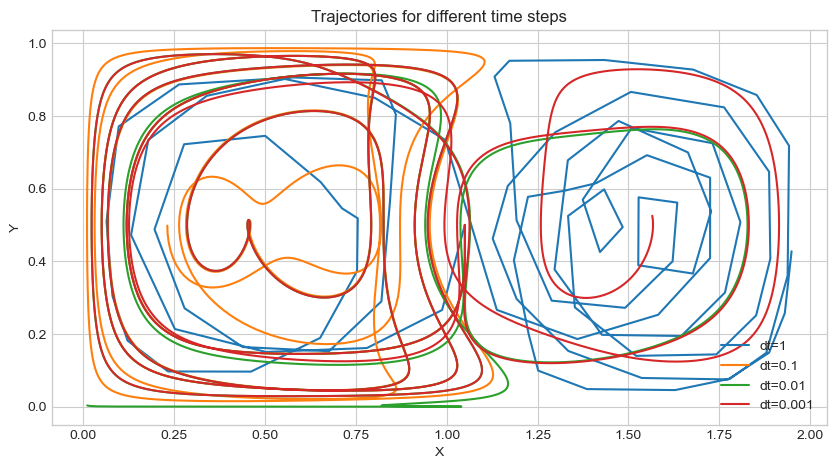

In [233]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
x0 = np.array([[1.05], [0.50]])
for dt in [1, 0.1, 0.01, 0.001]:
    traj_a = Trajectory(x0, T=(0, 100), dt=dt)
    Y_a = traj_a(velocity)
    ax.plot(Y_a[:, 0, :], Y_a[:, 1, :], label=f"dt={dt}")

ax.legend()
ax.set_title("Trajectories for different time steps")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.grid(True)
ax.set_aspect("equal")

## Oppgave 1b)

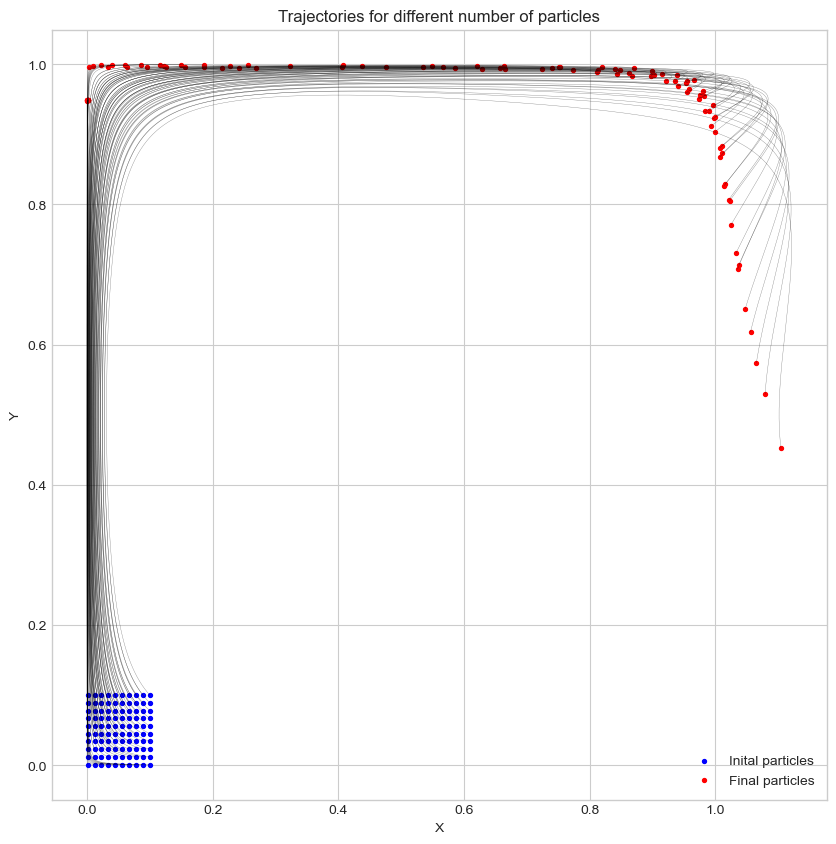

In [234]:
traj = Trajectory(T=(0, 10), dt=0.01, Np=100)
traj.initialize_particles(mode="grid", size=0.1)

X = traj(velocity)
V = traj.get_velocity()

fig, ax = plt.subplots(1, 1,figsize=(10, 10)) 

ax.plot(X[:, 0, :], X[:, 1, :], alpha=0.5, lw=0.25, color="black")
ax.scatter(X[0, 0, :], X[0, 1, :], label="Inital particles", s=8, color="blue")
ax.scatter(X[-1, 0, :], X[-1, 1, :], label="Final particles", s=8, color="red")

ax.set_title("Trajectories for different number of particles")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.legend()
ax.grid(True)
plt.show()

## Oppgave 1c)

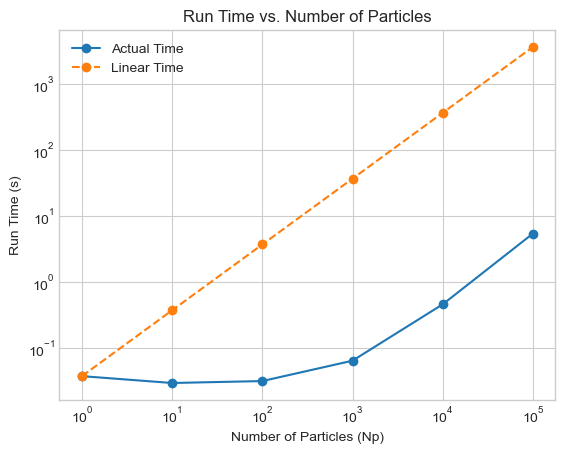

In [257]:
def run_timing_test(func, T, dt=0.01, Np_values=[1, 10, 100, 1000, 10000, 100000]):
    times = []
    for Np in Np_values:
        X0 = np.random.rand(2, Np)  # Initialize random particle positions
        start_time = time.time()
        traj = Trajectory(x0=X0, T=T, dt=dt)
        traj(func)
        end_time = time.time()
        times.append(end_time - start_time)
    linear_times = [Np * (times[0] / Np_values[0]) for Np in Np_values]
    return Np_values, linear_times, times


def plot_times(Np_values, linear_times, times):
    plt.plot(Np_values, times, marker="o", label="Actual Time")
    plt.plot(Np_values, linear_times, marker="o", linestyle="--", label="Linear Time")
    plt.xlabel("Number of Particles (Np)")
    plt.ylabel("Run Time (s)")
    plt.xscale("log")
    plt.yscale("log")
    plt.title("Run Time vs. Number of Particles")
    plt.legend()
    plt.grid(True)
    plt.show()


Np_values, linear_times, times = run_timing_test(velocity, T=(0, 10))
plot_times(Np_values, linear_times, times)

The graph shows the curve is approximately constant for fewer particles, i.e. shorter arrays. A possible expination is that for smaller array-sizes, the compiler overestimates how much memory needs to be allocated. Adding elements threrfore doesn't require additional runtime, resulting in constant time $\mathcal{O}(1)$. For bigger array-sizes, Python needs to allocate memory more frequently, resulting in a linear increase of runtime $\mathcal{O}(n)$.

---

# Problem 2

## ( 2-a )
$\hat{x} = 790.000$ og $\hat{y} = 490.000$

In [ ]:
d  = xr.open_dataset('data/NorKyst-800m.nc')
f = Interpolator(dataset=d)

traj = Trajectory(T=(0, 7*24*3600), dt=3600, Np=1000)
traj.initialize_particles(mode="random", loc=[790000, 490000], scale=10000)

X = traj(f)
V = traj.get_velocity()
L = traj.get_land_particles()

plot_map(f, X, V, figsize=(15, 12), extent=(7, 11, 63.5, 66), s=4, scatter_color=("blue", "red"), plot_linewidth=0.2, plot_color="lightblue", alpha=0.05, stream_linewidth=1, stream_color="black", density=1.5)

In [ ]:
print(L)

## ( 2-b )
LEGG INN LOC VERDIER
**grenseverdier norge**
- lengdegrad 58, 73 grader nord
- breddegrad: 5 , 35 grader øst

In [ ]:
print(L)

In [ ]:
d  = xr.open_dataset('data/NorKyst-800m.nc')
f = Interpolator(dataset=d)
traj_2 = Trajectory(T=(0, 7*24*3600), dt=3600, Np=100)
traj_2.initialize_particles(mode="random", loc=[24000, 12000], scale=5000)
X = traj_2(f)
V = traj_2.get_velocity()
plot_map(f, X, V, figsize=(15, 12), extent=(7, 15, 48, 72), s=2, scatter_color=("blue", "red"), plot_linewidth=0.1, plot_color="lightblue", alpha=0.1, stream_linewidth=1, stream_color="black", density=1)

In [ ]:

traj_3 = Trajectory(T=(0, 7*24*3600), dt=3600, Np=1000)
traj_3.initialize_particles(mode="random", loc=[1900000, 430000], scale=10000)
X = traj_3(f)
V = traj_3.get_velocity()

plot_map(f, X, V, figsize=(15, 12), extent=(18, 30, 70, 74), s=2, scatter_color=("blue", "red"), plot_linewidth=0.1, plot_color="lightblue", alpha=0.1, stream_linewidth=1, stream_color="black", density=3)


# Problem 3
## ( 3-a )

In [ ]:
d  = xr.open_dataset('data/NorKyst-800m.nc')
f  = Interpolator(dataset = d)
Np = 500
traj = Trajectory(T=(0, 3*24*3600), dt=3600, Np=Np)
traj.initialize_particles(mode="random", loc=(250000, 460000), scale=10000)
Y = traj(f)
V = traj.get_velocity()
L = traj.get_land_particles()
plot_map(f, Y, V, L=L, figsize=(12, 10), extent=(2, 9, 61, 61.5), s=6, plot_linewidth=0.1, plot_color="grey", alpha=0.5, stream_linewidth=1, stream_color="black", density=1)

## ( 3-b )